# HMM vs kmeans vs Jump vs Sparse Jump Simulation study (Gaussian)

This script illustrates how to replicate a simulation study using the "temporal features" approach from Nystrup et al. (2020). We simulate data from a 2-state Gaussian HMM (univariate), then transform it into features, and finally apply:
1) HMM (from hmmlearn)
2) Jump Model
3) Sparse Jump Model

We'll demonstrate how to tune hyperparameters (penalty parameters, etc.) for the jump-based models.
In a real scenario, you may want more robust approaches (e.g., cross-validation).


### 1.0 Loading Packages

In [39]:
#Load Packages
import numpy as np
import pandas as pd
from hmmlearn.hmm import GaussianHMM  # Import GaussianHMM
from sklearn.metrics import balanced_accuracy_score, confusion_matrix
from scipy.optimize import linear_sum_assignment
from jumpmodels.sparse_jump import SparseJumpModel
from jumpmodels.jump import JumpModel
from scipy import stats
from scipy.stats import t
from joblib import Parallel, delayed
import multiprocessing
from scipy.stats import wilcoxon
from jumpmodels.preprocess import StandardScalerPD, DataClipperStd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import matplotlib.ticker as mticker



### 2. Data Simulation & Utility Functions

We simulate a univariate 2-state Gaussian HMM. We then define functions for:
  - Aligning predicted labels with true labels (Hungarian algorithm).
  - Computing balanced accuracy.

In [19]:
def simulate_data(T, random_state=None):
    """
    Simulate data from a 2-state HMM using a Student's t-distribution with 5 degrees of freedom.
    
    Parameters:
      T : int - number of observations
      random_state : int or None - seed for reproducibility
      
    Returns:
      y : array of observations
      states : array of true state labels
    """
    rng = np.random.default_rng(random_state)

    # True parameters (from Nystrup et al. 2020b)
    mu1, mu2 = 0.000615, -0.000785
    sigma1, sigma2 = 0.007759, 0.02140
    transmat = np.array([[0.9979, 0.0021],
                         [0.0120, 0.9880]])

    # Compute stationary distribution
    eigvals, eigvecs = np.linalg.eig(transmat.T)
    stat = np.real(eigvecs[:, np.isclose(eigvals, 1)])
    stat = stat[:, 0] / np.sum(stat[:, 0])

    # Generate state sequence
    states = np.zeros(T, dtype=int)
    states[0] = rng.choice([0, 1], p=stat)
    for t in range(1, T):
        states[t] = rng.choice([0, 1], p=transmat[states[t - 1]])

    # Use a t-distribution with 5 degrees of freedom for all observations.
    df_t = 5
    y = np.zeros(T)
    for t in range(T):
        # Select parameters based on state
        if states[t] == 0:
            mu, sigma = mu1, sigma1
        else:
            mu, sigma = mu2, sigma2
        
        # Adjust the scale so that the t-distribution has the same variance as the Gaussian:
        # Variance of a t-distribution with df degrees is df/(df-2) (if df > 2).
        # Therefore, to have variance sigma^2, we need scale = sigma * sqrt((df - 2)/df)
        scale = sigma * np.sqrt((df_t - 2) / df_t)
        # Draw a t-distributed random value and shift/scale it:
        y[t] = mu + scale * rng.standard_t(df_t)
    
    return y, states

### 2.1 Alligning Predicted labels using Hungarian Algorithm

In [20]:
def align_labels(true_labels, pred_labels):
    """
    Align predicted labels with true labels using the Hungarian algorithm.
    If a predicted label is not found in the mapping, it returns the original label.
    """
    cm = confusion_matrix(true_labels, pred_labels)
    row_ind, col_ind = linear_sum_assignment(-cm)
    mapping = {col: row for row, col in zip(col_ind, row_ind)}
    aligned = np.array([mapping.get(x, x) for x in pred_labels])
    return aligned

### 2.2 Function for calculating the BAC

In [21]:
def calculate_bac(true_states, pred_states):
    """
    Compute Balanced Accuracy (BAC) after aligning predicted state labels.
    """
    aligned_pred = align_labels(true_states, pred_states)
    return balanced_accuracy_score(true_states, aligned_pred)

### 2.3 Per state Accuracy function

In [22]:

def compute_per_state_accuracy(true_states, pred_states):
    """
    Returns (acc1, acc2, BAC) where:
      acc1 = fraction of true-state=0 samples predicted as 0,
      acc2 = fraction of true-state=1 samples predicted as 1,
      BAC  = 0.5*(acc1+acc2)
    """
    aligned_pred = align_labels(true_states, pred_states)
    cm = confusion_matrix(true_states, aligned_pred, labels=[0, 1])
    denom_0 = cm[0, :].sum()
    denom_1 = cm[1, :].sum()
    acc1 = cm[0, 0] / denom_0 if denom_0 > 0 else 0
    acc2 = cm[1, 1] / denom_1 if denom_1 > 0 else 0
    bac = 0.5 * (acc1 + acc2)
    return acc1, acc2, bac


def compute_state_statistics(y, true_states, pred_states):
    """
    Compute the mean return and volatility (std) of the raw observations y for each state.
    The predicted labels are first aligned with the true labels.
    Returns a dictionary with keys:
      'state0_mean', 'state0_vol', 'state1_mean', 'state1_vol'
    """
    aligned = align_labels(true_states, pred_states)
    stats_dict = {}
    for state in [0, 1]:
        idx = np.where(aligned == state)[0]
        if len(idx) > 0:
            stats_dict[f"state{state}_mean"] = np.mean(y[idx])
            stats_dict[f"state{state}_vol"] = np.std(y[idx])
        else:
            stats_dict[f"state{state}_mean"] = np.nan
            stats_dict[f"state{state}_vol"] = np.nan
    return stats_dict

def compute_transition_probabilities(state_seq):
    """
    Compute transition probabilities for a two-state model from a state sequence.
    Returns:
      gamma12 = (# transitions from state 0 to 1) / (# transitions from state 0)
      gamma21 = (# transitions from state 1 to 0) / (# transitions from state 1)
    """
    state_seq = np.array(state_seq)
    prev_states = state_seq[:-1]
    next_states = state_seq[1:]
    if np.sum(prev_states == 0) > 0:
        gamma12 = np.sum((prev_states == 0) & (next_states == 1)) / np.sum(prev_states == 0)
    else:
        gamma12 = np.nan
    if np.sum(prev_states == 1) > 0:
        gamma21 = np.sum((prev_states == 1) & (next_states == 0)) / np.sum(prev_states == 1)
    else:
        gamma21 = np.nan
    return gamma12, gamma21


def viterbi_true(y):
    """
    Decode the state sequence using the true parameters from Nystrup et al. (2020b):
      mu1 = 0.000615, mu2 = -0.000785,
      sigma1 = 0.007759, sigma2 = 0.02140,
      transmat = [[0.9979, 0.0021],
                  [0.0120, 0.9880]]
    Returns a numpy array with the decoded state sequence.
    """
    T = len(y)
    mu = [0.000615, -0.000785]
    sigma = [0.007759, 0.02140]
    transmat = np.array([[0.9979, 0.0021],
                         [0.0120, 0.9880]])
    # Compute stationary distribution
    eigvals, eigvecs = np.linalg.eig(transmat.T)
    stat = np.real(eigvecs[:, np.isclose(eigvals, 1)])
    stat = stat[:, 0] / np.sum(stat[:, 0])
    
    delta = np.zeros((T, 2))
    psi = np.zeros((T, 2), dtype=int)
    # Initialization:
    delta[0,0] = np.log(stat[0]) + stats.norm.logpdf(y[0], loc=mu[0], scale=sigma[0])
    delta[0,1] = np.log(stat[1]) + stats.norm.logpdf(y[0], loc=mu[1], scale=sigma[1])
    psi[0, :] = 0
    # Recursion:
    for t in range(1, T):
        for j in range(2):
            temp = delta[t-1] + np.log(transmat[:, j])
            psi[t, j] = np.argmax(temp)
            # For j==0 use mu[0], sigma[0]; for j==1 use mu[1], sigma[1]
            delta[t, j] = np.max(temp) + stats.norm.logpdf(y[t], loc=mu[j], scale=sigma[j])
    # Backtracking:
    states = np.zeros(T, dtype=int)
    states[T-1] = np.argmax(delta[T-1])
    for t in range(T-2, -1, -1):
        states[t] = psi[t+1, states[t+1]]
    return states


## 3.0 Model Wrappers

We'll define functions to:
  - Fit a standard HMM (hmmlearn)
  - Fit Jump Model penalty
  - Fit Sparse Jump Model penalties

### 3.1 Fit a GaussianHMM with two different initilizations

In [23]:
def run_mle(observations, n_components=2, init_type='default', seed=None):
    """
    Fit a GaussianHMM to the raw observations.
    Returns (model, states_est).
    """
    # Use the seed provided (or None if not given) for the HMM RNG
    model = GaussianHMM(n_components=n_components, covariance_type="diag", n_iter=100, random_state=seed)
    
    if init_type == 'default':
        model.startprob_ = np.array([1.0, 0.0])
        model.transmat_ = np.array([[0.9, 0.1],
                                    [0.1, 0.9]])
        model.means_ = np.array([[0.0], [0.0]])
        model.covars_ = np.array([[0.01], [0.01]])
        model.init_params = ''
    
    elif init_type == 'kmeans':
        from sklearn.cluster import KMeans
        # Instead of a fixed 42, use the seed passed to run_mle
        kmeans = KMeans(
            n_clusters=n_components,
            n_init=10,          # try 10 different seeds
            random_state=seed   # variable seed for different runs
        ).fit(observations.reshape(-1, 1))
        labels = kmeans.labels_
        
        # Compute means & variances for each cluster
        means = []
        covars = []
        for i in range(n_components):
            obs_i = observations[labels == i]
            means.append(np.mean(obs_i))
            var_ = np.var(obs_i) if len(obs_i) > 0 else 0.01
            covars.append(var_)
        
        model.startprob_ = np.ones(n_components) / n_components
        model.transmat_ = np.ones((n_components, n_components)) / n_components
        model.means_ = np.array(means).reshape(-1, 1)
        model.covars_ = np.array(covars).reshape(-1, 1)
        model.init_params = 'tmc'
    
    model.fit(observations.reshape(-1, 1))
    _, states_est = model.decode(observations.reshape(-1, 1))
    return model, states_est

### 3.2 Fitting a jump model with fixed hyperparameters

In [24]:
def run_jump_model(Z, n_components=2, lambda_=100.0, random_state=None):
    """
    Fit a JumpModel to standardized feature matrix Z.
    Returns predicted state labels.
    """
    jm = JumpModel(
        n_components=n_components,
        jump_penalty=lambda_,
        cont=False,
        max_iter=10,
        random_state=random_state
    )
    jm.fit(Z)
    return jm.labels_

### 3.3 Fitting a sparse jump model with fixed hyperparameters

In [25]:
def run_sparse_jump_model(Z, n_components=2, lambda_=10.0, max_feats=10, random_state=None):
    """
    Fit a SparseJumpModel to standardized feature matrix Z.
    Returns predicted state labels.
    """
    sjm = SparseJumpModel(
        n_components=n_components,
        jump_penalty=lambda_,
        cont=False,
        max_feats=max_feats,
        max_iter=10,
        random_state=random_state
    )
    sjm.fit(Z)
    return sjm.labels_

### 3.4 Features from Algorithm 2

Given a univariate time series `y`, the function will return the following features:

1. **Observation:** \( y[t] \)  
2. **Left absolute change:** \(\left| y[t] - y[t-1] \right|\)  
3. **Right absolute change:** \(\left| y[t+1] - y[t] \right|\)  
4. **Centered local mean:** \(\text{mean}(y[t-(l-1)/2 : t+(l-1)/2])\)  
5. **Centered local std**  
6. **Left local mean**  
7. **Left local std**  
8. **Right local mean**  
9. **Right local std**

In [26]:
def compute_temporal_features(y, l):
    """
    Compute the 9 features from Algorithm 2 for window length l.
    Returns an array of shape (T, 9).
    """
    T = len(y)
    feats = np.zeros((T, 9), dtype=float)
    half = (l - 1) // 2
    for t in range(T):
        feats[t, 0] = y[t]
        feats[t, 1] = abs(y[t] - y[t-1]) if t > 0 else 0.
        feats[t, 2] = abs(y[t+1] - y[t]) if t < (T-1) else 0.
        left_c = max(0, t - half)
        right_c = min(T, t + half + 1)
        window_c = y[left_c:right_c]
        feats[t, 3] = np.mean(window_c)
        feats[t, 4] = np.std(window_c)
        left_l = max(0, t - l)
        right_l = t
        window_l = y[left_l:right_l]
        feats[t, 5] = np.mean(window_l) if len(window_l) > 0 else 0.
        feats[t, 6] = np.std(window_l) if len(window_l) > 0 else 0.
        left_r = t
        right_r = min(T, t + l)
        window_r = y[left_r:right_r]
        feats[t, 7] = np.mean(window_r) if len(window_r) > 0 else 0.
        feats[t, 8] = np.std(window_r) if len(window_r) > 0 else 0.
    return feats


def combine_features(y, l_list=[5, 13]):
    """
    For each window length in l_list, compute the 9 features and horizontally stack them.
    Returns an array of shape (T, 9 * len(l_list)).
    """
    feat_list = []
    for l in l_list:
        feat_list.append(compute_temporal_features(y, l))
    return np.hstack(feat_list)

### 4.0 Main execution

### 4.1 Workhorse funciton

In [27]:
def run_one_simulation(seed, T=250, lambda_jump=30.0, lambda_sjump=32.0, max_feats=1):
    """
    Single simulation run:
      1) Simulate data (y, true_states)
      2) Build & standardize features Z for jump-based models
      3) Fit HMM (MLE default init) on raw y, extract parameters, compute per-state stats and BAC
      4) Fit HMM (MLE k-means init) on raw y, extract parameters, compute per-state stats and BAC
      5) Fit JumpModel on standardized features and compute BAC & state stats
      6) Fit SparseJumpModel on standardized features and compute BAC & state stats
      7) Return a dictionary with all metrics.
    """
    # 1) Simulate data
    y, true_states = simulate_data(T, random_state=seed)

    # 1.1) rue decoding using the true parameters ---
    pred_true = viterbi_true(y)  # assumes you have defined a viterbi_true(y) function using the true parameters
    acc1_true, acc2_true, bac_true = compute_per_state_accuracy(true_states, pred_true)
    state_stats_true = compute_state_statistics(y, true_states, pred_true)

    # 2) Compute features and standardize for jump-based models
    Z = combine_features(y, l_list=[5, 13])
    Z_df = pd.DataFrame(Z)
    clipper = DataClipperStd(mul=3.0)
    scaler = StandardScalerPD()
    Z_clipped = clipper.fit_transform(Z_df)
    Z_scaled = scaler.fit_transform(Z_clipped)
    Z_scaled_arr = Z_scaled.values

    # --- HMM (MLE default init) on raw y ---
    model_mle, states_est_mle = run_mle(y, n_components=2, init_type='default')
    acc1_mle, acc2_mle, bac_mle = compute_per_state_accuracy(true_states, states_est_mle)
    state_stats_mle = compute_state_statistics(y, true_states, states_est_mle)
    mu1_mle = float(model_mle.means_[0, 0])
    mu2_mle = float(model_mle.means_[1, 0])
    sigma1_mle = float(np.sqrt(model_mle.covars_[0, 0]))
    sigma2_mle = float(np.sqrt(model_mle.covars_[1, 0]))
    gamma12_mle = float(model_mle.transmat_[0, 1])
    gamma21_mle = float(model_mle.transmat_[1, 0])

    # --- HMM (MLE k-means init) on raw y ---
    model_mle_k, states_est_mle_k = run_mle(y, n_components=2, init_type='kmeans')
    acc1_mlek, acc2_mlek, bac_mlek = compute_per_state_accuracy(true_states, states_est_mle_k)
    state_stats_mlek = compute_state_statistics(y, true_states, states_est_mle_k)
    mu1_mlek = float(model_mle_k.means_[0, 0])
    mu2_mlek = float(model_mle_k.means_[1, 0])
    sigma1_mlek = float(np.sqrt(model_mle_k.covars_[0, 0]))
    sigma2_mlek = float(np.sqrt(model_mle_k.covars_[1, 0]))
    gamma12_mlek = float(model_mle_k.transmat_[0, 1])
    gamma21_mlek = float(model_mle_k.transmat_[1, 0])

 # --- JumpModel on standardized features ---
    pred_jump = run_jump_model(Z_scaled_arr, n_components=2, lambda_=lambda_jump, random_state=seed)
    acc1_jump, acc2_jump, bac_jump = compute_per_state_accuracy(true_states, pred_jump)
    state_stats_jump = compute_state_statistics(y, true_states, pred_jump)
    gamma12_jump, gamma21_jump = compute_transition_probabilities(pred_jump)  # NEW

    # --- SparseJumpModel on standardized features ---
    pred_sjump = run_sparse_jump_model(Z_scaled_arr, n_components=2, lambda_=lambda_sjump,
                                       max_feats=max_feats, random_state=seed)
    acc1_sjump, acc2_sjump, bac_sjump = compute_per_state_accuracy(true_states, pred_sjump)
    state_stats_sjump = compute_state_statistics(y, true_states, pred_sjump)
    gamma12_sjump, gamma21_sjump = compute_transition_probabilities(pred_sjump)  # NEW

    return {
        "seed": seed,
        "T": T,
        # True decoding using the true parameters
        "True_state0_mean": state_stats_true["state0_mean"],
        "True_state0_vol": state_stats_true["state0_vol"],
        "True_state1_mean": state_stats_true["state1_mean"],
        "True_state1_vol": state_stats_true["state1_vol"],
        "True_acc1": acc1_true,
        "True_acc2": acc2_true,
        "True_BAC": bac_true,
        # MLE default parameters and state stats (unchanged)
        "MLE_mu1": mu1_mle, "MLE_mu2": mu2_mle,
        "MLE_sigma1": sigma1_mle, "MLE_sigma2": sigma2_mle,
        "MLE_gamma12": gamma12_mle, "MLE_gamma21": gamma21_mle,
        "MLE_acc1": acc1_mle, "MLE_acc2": acc2_mle, "MLE_BAC": bac_mle,
        "MLE_state0_mean": state_stats_mle["state0_mean"],
        "MLE_state0_vol": state_stats_mle["state0_vol"],
        "MLE_state1_mean": state_stats_mle["state1_mean"],
        "MLE_state1_vol": state_stats_mle["state1_vol"],
        # MLE k-means parameters and state stats (unchanged)
        "MLEK_mu1": mu1_mlek, "MLEK_mu2": mu2_mlek,
        "MLEK_sigma1": sigma1_mlek, "MLEK_sigma2": sigma2_mlek,
        "MLEK_gamma12": gamma12_mlek, "MLEK_gamma21": gamma21_mlek,
        "MLEK_acc1": acc1_mlek, "MLEK_acc2": acc2_mlek, "MLEK_BAC": bac_mlek,
        "MLEK_state0_mean": state_stats_mlek["state0_mean"],
        "MLEK_state0_vol": state_stats_mlek["state0_vol"],
        "MLEK_state1_mean": state_stats_mlek["state1_mean"],
        "MLEK_state1_vol": state_stats_mlek["state1_vol"],
        # JumpModel state stats and gamma (UPDATED)
        "Jump_acc1": acc1_jump, "Jump_acc2": acc2_jump, "Jump_BAC": bac_jump,
        "Jump_state0_mean": state_stats_jump["state0_mean"],
        "Jump_state0_vol": state_stats_jump["state0_vol"],
        "Jump_state1_mean": state_stats_jump["state1_mean"],
        "Jump_state1_vol": state_stats_jump["state1_vol"],
        "Jump_gamma12": gamma12_jump, "Jump_gamma21": gamma21_jump,  # NEW
        # SparseJumpModel state stats and gamma (UPDATED)
        "SparseJump_acc1": acc1_sjump, "SparseJump_acc2": acc2_sjump, "SparseJump_BAC": bac_sjump,
        "SparseJump_state0_mean": state_stats_sjump["state0_mean"],
        "SparseJump_state0_vol": state_stats_sjump["state0_vol"],
        "SparseJump_state1_mean": state_stats_sjump["state1_mean"],
        "SparseJump_state1_vol": state_stats_sjump["state1_vol"],
        "SparseJump_gamma12": gamma12_sjump, "SparseJump_gamma21": gamma21_sjump  # NEW
    }

### 4.2 Main Execution

In [ ]:
if __name__ == "__main__":
    # Define simulation lengths and number of simulations per T
    T_values = [250, 500, 1000, 2000]
    n_simulations = 1000

    # Hyperparameters for jump-based models
    lambda_jump = 100.0
    lambda_sjump = 100.0
    max_feats = 9

    num_cores = multiprocessing.cpu_count()
    print(f"Running {n_simulations} simulations per T value on {num_cores} cores...")

    all_results = []
    for T in T_values:
        print(f"\nRunning simulations for T = {T}...")
        seeds = np.arange(n_simulations)
        results_list = Parallel(n_jobs=num_cores)(
            delayed(run_one_simulation)(
                seed=s,
                T=T,
                lambda_jump=lambda_jump,
                lambda_sjump=lambda_sjump,
                max_feats=max_feats
            ) for s in seeds
        )
        df_results_T = pd.DataFrame(results_list)
        all_results.append(df_results_T)

    final_results = pd.concat(all_results, ignore_index=True)

    # Print summary statistics for each T value
    for T in T_values:
        df_T = final_results[final_results["T"] == T]
        print(f"\n=== Results Summary for T = {T} ===")
        # MLE default parameters
        for param in ["MLE_mu1", "MLE_mu2", "MLE_sigma1", "MLE_sigma2", "MLE_gamma12", "MLE_gamma21"]:
            mean_val = df_T[param].mean()
            std_val = df_T[param].std()
            print(f"{param}: {mean_val:.4f} ± {std_val:.4f}")
        # MLE default state stats
        for stat in ["MLE_state0_mean", "MLE_state0_vol", "MLE_state1_mean", "MLE_state1_vol"]:
            mean_val = df_T[stat].mean()
            std_val = df_T[stat].std()
            print(f"{stat}: {mean_val:.4f} ± {std_val:.4f}")
        # MLE k-means parameters
        for param in ["MLEK_mu1", "MLEK_mu2", "MLEK_sigma1", "MLEK_sigma2", "MLEK_gamma12", "MLEK_gamma21"]:
            mean_val = df_T[param].mean()
            std_val = df_T[param].std()
            print(f"{param}: {mean_val:.4f} ± {std_val:.4f}")
        # MLE k-means state stats
        for stat in ["MLEK_state0_mean", "MLEK_state0_vol", "MLEK_state1_mean", "MLEK_state1_vol"]:
            mean_val = df_T[stat].mean()
            std_val = df_T[stat].std()
            print(f"{stat}: {mean_val:.4f} ± {std_val:.4f}")
        # BAC values for each method
        print(f"MLE default BAC: {df_T['MLE_BAC'].mean():.3f} ± {df_T['MLE_BAC'].std():.3f}")
        print(f"MLE k-means BAC: {df_T['MLEK_BAC'].mean():.3f} ± {df_T['MLEK_BAC'].std():.3f}")
        print(f"Jump Model BAC : {df_T['Jump_BAC'].mean():.3f} ± {df_T['Jump_BAC'].std():.3f}")
        print(f"Sparse Jump BAC: {df_T['SparseJump_BAC'].mean():.3f} ± {df_T['SparseJump_BAC'].std():.3f}")

    print("\nSample of raw results (first 10 rows):")
    print(final_results.head(10))

Running 30 simulations per T value on 8 cores...

Running simulations for T = 250...


/Users/vlad/Desktop/git/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/Users/vlad/Desktop/git/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/Users/vlad/Desktop/git/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/Users/vlad/Desktop/git/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label wa


Running simulations for T = 500...


/Users/vlad/Desktop/git/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/Users/vlad/Desktop/git/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/Users/vlad/Desktop/git/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/Users/vlad/Desktop/git/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label wa


Running simulations for T = 1000...


Model is not converging.  Current: 3315.319528632435 is not greater than 3316.1068243025725. Delta is -0.7872956701376097
Model is not converging.  Current: 3413.1123830751317 is not greater than 3414.1116672289063. Delta is -0.9992841537746244
/var/folders/mg/4q2pl8qx47b43dbs_tncwchh0000gn/T/ipykernel_33523/3664051572.py:35: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
/var/folders/mg/4q2pl8qx47b43dbs_tncwchh0000gn/T/ipykernel_33523/3664051572.py:36: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
/var/folders/mg/4q2pl8qx47b43dbs_tncwchh0000gn/T/ipykernel_33523/3664051572.py:35: DeprecationWarning: Conversion of an array with ndim > 0 to a sc


Running simulations for T = 2000...


Model is not converging.  Current: 6821.157787875057 is not greater than 6821.764066409912. Delta is -0.6062785348549369
Model is not converging.  Current: 6767.186072341802 is not greater than 6767.741802318306. Delta is -0.5557299765041535
/var/folders/mg/4q2pl8qx47b43dbs_tncwchh0000gn/T/ipykernel_33523/3664051572.py:35: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
/var/folders/mg/4q2pl8qx47b43dbs_tncwchh0000gn/T/ipykernel_33523/3664051572.py:36: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
/var/folders/mg/4q2pl8qx47b43dbs_tncwchh0000gn/T/ipykernel_33523/3664051572.py:35: DeprecationWarning: Conversion of an array with ndim > 0 to a scala


=== Results Summary for T = 250 ===
MLE_mu1: -0.0023 ± 0.0090
MLE_mu2: -0.0019 ± 0.0121
MLE_sigma1: 0.0205 ± 0.0223
MLE_sigma2: 9.5321 ± 14.7093
MLE_gamma12: 0.1135 ± 0.2605
MLE_gamma21: 0.5268 ± 0.4475
MLE_state0_mean: -0.0017 ± 0.0153
MLE_state0_vol: 0.0131 ± 0.0136
MLE_state1_mean: -0.0091 ± 0.0207
MLE_state1_vol: 0.0191 ± 0.0136
MLEK_mu1: -0.0036 ± 0.0139
MLEK_mu2: -0.0012 ± 0.0127
MLEK_sigma1: 3.8663 ± 10.1264
MLEK_sigma2: 6.3646 ± 12.8451
MLEK_gamma12: 0.3300 ± 0.4465
MLEK_gamma21: 0.6004 ± 0.4694
MLEK_state0_mean: -0.0039 ± 0.0261
MLEK_state0_vol: 0.0128 ± 0.0155
MLEK_state1_mean: -0.0077 ± 0.0201
MLEK_state1_vol: 0.0213 ± 0.0167
MLE default BAC: 0.557 ± 0.134
MLE k-means BAC: 0.536 ± 0.102
Jump Model BAC : 0.677 ± 0.262
Sparse Jump BAC: 0.680 ± 0.265

=== Results Summary for T = 500 ===
MLE_mu1: 0.0007 ± 0.0058
MLE_mu2: 0.0020 ± 0.0088
MLE_sigma1: 0.0173 ± 0.0178
MLE_sigma2: 0.0266 ± 0.0190
MLE_gamma12: 0.1102 ± 0.2426
MLE_gamma21: 0.2374 ± 0.3528
MLE_state0_mean: 0.0006 ± 0.0

### 5 Data summary

#### 5.1 Table 1 sumamry

In [29]:
# True parameters from Nystrup et al. (2020b)
true_params = {
            "state0_mean": df_T["True_state0_mean"].mean(),
            "state1_mean": df_T["True_state1_mean"].mean(),
            "state0_vol": df_T["True_state0_vol"].mean(),
            "state1_vol": df_T["True_state1_vol"].mean(),
            "gamma12": 0.0021,   # true value from Nystrup et al.
            "gamma21": 0.0120,   # true value from Nystrup et al.
            "acc1": df_T["True_acc1"].mean(),
            "acc2": df_T["True_acc2"].mean(),
            "BAC":  df_T["True_BAC"].mean()
}

T_values = final_results["T"].unique()

for T_val in sorted(T_values):
    df_T = final_results[final_results["T"] == T_val]
    
    # Build a dictionary of rows = { "method" : {col: value, ...} }
    summary_dict = {
        "True": true_params,
        "MLE default": {
            "state0_mean": df_T["MLE_state0_mean"].mean(),
            "state1_mean": df_T["MLE_state1_mean"].mean(),
            "state0_vol": df_T["MLE_state0_vol"].mean(),
            "state1_vol": df_T["MLE_state1_vol"].mean(),
            "gamma12": df_T["MLE_gamma12"].mean(),
            "gamma21": df_T["MLE_gamma21"].mean(),
            "acc1": df_T["MLE_acc1"].mean(),
            "acc2": df_T["MLE_acc2"].mean(),
            "BAC": df_T["MLE_BAC"].mean()
        },
        "MLE k-means": {
            "state0_mean": df_T["MLEK_state0_mean"].mean(),
            "state1_mean": df_T["MLEK_state1_mean"].mean(),
            "state0_vol": df_T["MLEK_state0_vol"].mean(),
            "state1_vol": df_T["MLEK_state1_vol"].mean(),
            "gamma12": df_T["MLEK_gamma12"].mean(),
            "gamma21": df_T["MLEK_gamma21"].mean(),
            "acc1": df_T["MLEK_acc1"].mean(),
            "acc2": df_T["MLEK_acc2"].mean(),
            "BAC": df_T["MLEK_BAC"].mean()
        },
        "Jump Model": {
            "state0_mean": df_T["Jump_state0_mean"].mean(),
            "state1_mean": df_T["Jump_state1_mean"].mean(),
            "state0_vol": df_T["Jump_state0_vol"].mean(),
            "state1_vol": df_T["Jump_state1_vol"].mean(),
            "gamma12": df_T["Jump_gamma12"].mean(),
            "gamma21": df_T["Jump_gamma21"].mean(),
            "acc1": df_T["Jump_acc1"].mean(),
            "acc2": df_T["Jump_acc2"].mean(),
            "BAC": df_T["Jump_BAC"].mean()
        },
        "Sparse Jump": {
            "state0_mean": df_T["SparseJump_state0_mean"].mean(),
            "state1_mean": df_T["SparseJump_state1_mean"].mean(),
            "state0_vol": df_T["SparseJump_state0_vol"].mean(),
            "state1_vol": df_T["SparseJump_state1_vol"].mean(),
            "gamma12": df_T["SparseJump_gamma12"].mean(),
            "gamma21": df_T["SparseJump_gamma21"].mean(),
            "acc1": df_T["SparseJump_acc1"].mean(),
            "acc2": df_T["SparseJump_acc2"].mean(),
            "BAC": df_T["SparseJump_BAC"].mean()
        }
    }
    
    # Convert to DataFrame and transpose so methods become rows
    summary_df = pd.DataFrame(summary_dict).T
    
    # Optionally, you can reorder columns if you like:
    # (This ensures a consistent column order in the final output)
    col_order = [
        "state0_mean", "state1_mean",
        "state0_vol", "state1_vol",
        "gamma12", "gamma21",
        "acc1", "acc2", "BAC"
    ]
    summary_df = summary_df[col_order]

    print(f"\nSummary for T = {T_val}")
    print(summary_df)


Summary for T = 250
             state0_mean  state1_mean  state0_vol  state1_vol   gamma12   gamma21      acc1      acc2       BAC
True            0.000635    -0.000100    0.007479    0.023348  0.002100  0.012000  0.992140  0.888878  0.940509
MLE default    -0.001655    -0.009082    0.013134    0.019146  0.113517  0.526789  0.832721  0.281054  0.556888
MLE k-means    -0.003911    -0.007652    0.012834    0.021327  0.329984  0.600430  0.798974  0.272863  0.535918
Jump Model      0.000786    -0.000886    0.007892    0.015775  0.003521  0.019670  0.892485  0.462036  0.677261
Sparse Jump     0.000769    -0.000779    0.007912    0.015778  0.003522  0.019101  0.893068  0.466957  0.680013

Summary for T = 500
             state0_mean  state1_mean  state0_vol  state1_vol   gamma12   gamma21      acc1      acc2       BAC
True            0.000635    -0.000100    0.007479    0.023348  0.002100  0.012000  0.992140  0.888878  0.940509
MLE default     0.000580     0.006916    0.007572    0.020277 

### 5.2 Statistical testing

In [45]:
# First, keep your existing helper function:
def safe_wilcoxon_series(s1, s2, atol=1e-10):
    df = pd.concat([s1, s2], axis=1, keys=['x', 'y']).dropna()
    if df.shape[0] == 0:
        return 1.0
    x_valid = df['x'].values
    y_valid = df['y'].values
    diff = x_valid - y_valid
    if np.allclose(diff, 0, atol=atol):
        return 1.0
    try:
        stat, p = wilcoxon(x_valid, y_valid)
        return p
    except ValueError:
        return np.nan

# Suppose you already have `final_results` from your simulations,
# along with your `metric_info` dict that tells columns for each metric.

T_values = [250, 500, 1000, 2000]  # or whatever sample sizes you used

for T_val in T_values:
    df_T = final_results[final_results["T"] == T_val]
    
    table_rows = []
    for metric, cols in metric_info.items():
        # Construct the right column names for the errors
        col_mlek   = f"MLEK_{metric.replace(' ', '_')}_error"
        col_jump   = f"Jump_{metric.replace(' ', '_')}_error"
        col_sparse = f"SparseJump_{metric.replace(' ', '_')}_error"

        series_mlek   = df_T[col_mlek]
        series_jump   = df_T[col_jump]
        series_sparse = df_T[col_sparse]

        # Medians
        med_mlek   = series_mlek.median()
        med_jump   = series_jump.median()
        med_sparse = series_sparse.median()

        # Pairwise p-values
        p_sparse_vs_jump = safe_wilcoxon_series(series_sparse, series_jump)
        p_jump_vs_mlek   = safe_wilcoxon_series(series_jump, series_mlek)
        p_sparse_vs_mlek = safe_wilcoxon_series(series_sparse, series_mlek)

        table_rows.append({
            "Parameter": metric,
            "MLEK Median Error": med_mlek,
            "Jump Median Error": med_jump,
            "SparseJump Median Error": med_sparse,
            "p (Sparse vs. Jump)": p_sparse_vs_jump,
            "p (Jump vs. MLEK)": p_jump_vs_mlek,
            "p (Sparse vs. MLEK)": p_sparse_vs_mlek
        })
    
    # Convert to DataFrame and display
    wilcoxon_table_T = pd.DataFrame(table_rows)
    print(f"\n=== Wilcoxon Results for T = {T_val} ===")
    print(wilcoxon_table_T.to_string(index=False, float_format='%.4f'))


=== Wilcoxon Results for T = 250 ===
        Parameter  MLEK Median Error  Jump Median Error  SparseJump Median Error  p (Sparse vs. Jump)  p (Jump vs. MLEK)  p (Sparse vs. MLEK)
     State 0 Mean             0.0007             0.0004                   0.0004               0.9588             0.0006               0.0009
     State 1 Mean             0.0017             0.0020                   0.0019               0.0061             0.5088               0.4061
      State 0 Vol             0.0005             0.0005                   0.0005               0.0787             0.1096               0.1034
      State 1 Vol             0.0126             0.0044                   0.0042               0.2553             0.0000               0.0000
        Gamma 0→1             0.0257             0.0025                   0.0025               0.5098             0.0000               0.0000
        Gamma 1→0             0.9785             0.0120                   0.0120               0.2604         

#### 5.3 Graphical summary

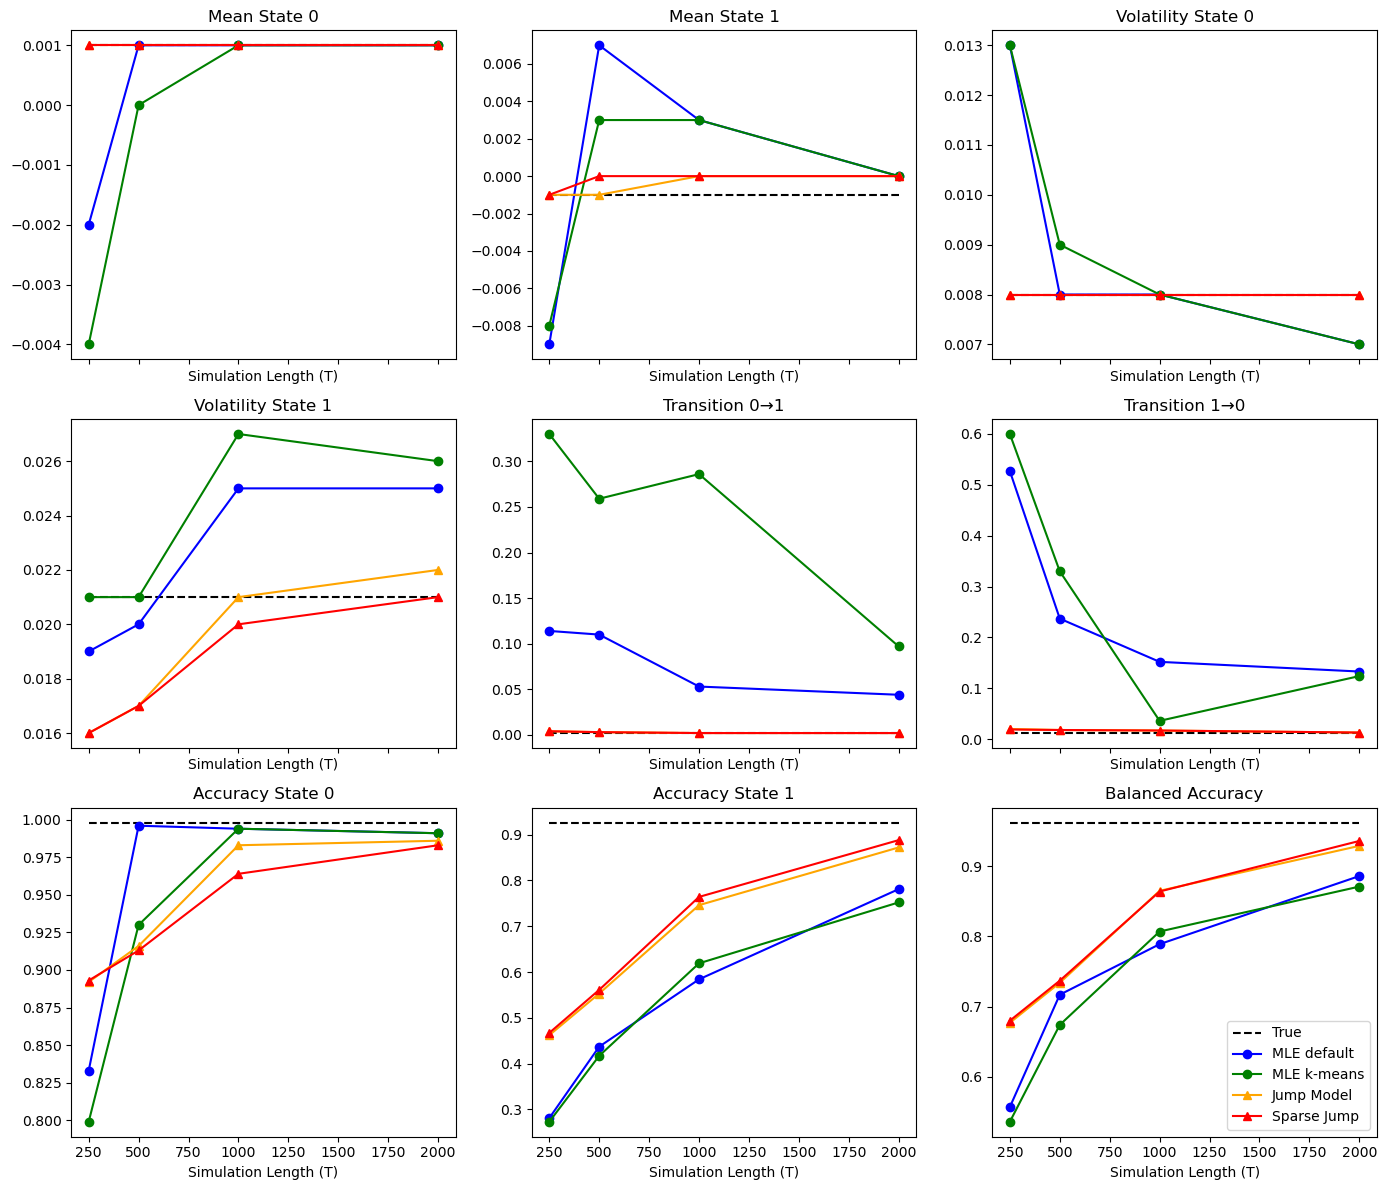

In [46]:
# -- 1) Build df_summary with fixed True values for all T --

# Constant True parameters from Nystrup et al. (2020b)
true_params = {
    "state0_mean": 0.000615,
    "state1_mean": -0.000785,
    "state0_vol": 0.007759,
    "state1_vol": 0.02140,
    "gamma12": 0.0021,
    "gamma21": 0.0120,
    "acc1": 0.997946,  # fixed value for True
    "acc2": 0.925937,
    "BAC": 0.961942
}

methods = ["True", "MLE default", "MLE k-means", "Jump Model", "Sparse Jump"]
T_values = sorted(final_results["T"].unique())
rows = []

for T_val in T_values:
    df_T = final_results[final_results["T"] == T_val]
    # Force True to be constant for all T:
    summary_dict = {
        "True": dict(true_params),
        "MLE default": {
            "state0_mean": df_T["MLE_state0_mean"].mean(),
            "state1_mean": df_T["MLE_state1_mean"].mean(),
            "state0_vol":  df_T["MLE_state0_vol"].mean(),
            "state1_vol":  df_T["MLE_state1_vol"].mean(),
            "gamma12": df_T["MLE_gamma12"].mean(),
            "gamma21": df_T["MLE_gamma21"].mean(),
            "acc1": df_T["MLE_acc1"].mean(),
            "acc2": df_T["MLE_acc2"].mean(),
            "BAC": df_T["MLE_BAC"].mean()
        },
        "MLE k-means": {
            "state0_mean": df_T["MLEK_state0_mean"].mean(),
            "state1_mean": df_T["MLEK_state1_mean"].mean(),
            "state0_vol":  df_T["MLEK_state0_vol"].mean(),
            "state1_vol":  df_T["MLEK_state1_vol"].mean(),
            "gamma12": df_T["MLEK_gamma12"].mean(),
            "gamma21": df_T["MLEK_gamma21"].mean(),
            "acc1": df_T["MLEK_acc1"].mean(),
            "acc2": df_T["MLEK_acc2"].mean(),
            "BAC": df_T["MLEK_BAC"].mean()
        },
        "Jump Model": {
            "state0_mean": df_T["Jump_state0_mean"].mean(),
            "state1_mean": df_T["Jump_state1_mean"].mean(),
            "state0_vol":  df_T["Jump_state0_vol"].mean(),
            "state1_vol":  df_T["Jump_state1_vol"].mean(),
            "gamma12": df_T["Jump_gamma12"].mean(),
            "gamma21": df_T["Jump_gamma21"].mean(),
            "acc1": df_T["Jump_acc1"].mean(),
            "acc2": df_T["Jump_acc2"].mean(),
            "BAC": df_T["Jump_BAC"].mean()
        },
        "Sparse Jump": {
            "state0_mean": df_T["SparseJump_state0_mean"].mean(),
            "state1_mean": df_T["SparseJump_state1_mean"].mean(),
            "state0_vol":  df_T["SparseJump_state0_vol"].mean(),
            "state1_vol":  df_T["SparseJump_state1_vol"].mean(),
            "gamma12": df_T["SparseJump_gamma12"].mean(),
            "gamma21": df_T["SparseJump_gamma21"].mean(),
            "acc1": df_T["SparseJump_acc1"].mean(),
            "acc2": df_T["SparseJump_acc2"].mean(),
            "BAC": df_T["SparseJump_BAC"].mean()
        }
    }
    
    for method_name, metrics in summary_dict.items():
        row = {"T": T_val, "Method": method_name}
        row.update(metrics)
        rows.append(row)

df_summary = pd.DataFrame(rows).round(3)

# -- 2) Plot in a 3×3 grid with custom line/marker styles --

# Define styles for each method:
method_styles = {
    "True":         {"linestyle": "--", "marker": None, "color": "black"},
    "MLE default":  {"linestyle": "-",  "marker": "o",  "color": "blue"},
    "MLE k-means":  {"linestyle": "-",  "marker": "o",  "color": "green"},
    "Jump Model":   {"linestyle": "-",  "marker": "^",  "color": "orange"},
    "Sparse Jump":  {"linestyle": "-",  "marker": "^",  "color": "red"}
}

# List of parameters to plot with pretty labels:
param_list = [
    ("state0_mean", "Mean State 0"),
    ("state1_mean", "Mean State 1"),
    ("state0_vol",  "Volatility State 0"),
    ("state1_vol",  "Volatility State 1"),
    ("gamma12",     "Transition 0→1"),
    ("gamma21",     "Transition 1→0"),
    ("acc1",        "Accuracy State 0"),
    ("acc2",        "Accuracy State 1"),
    ("BAC",         "Balanced Accuracy")
]

fig, axs = plt.subplots(3, 3, figsize=(14, 12), sharex=True)
axs = axs.ravel()

for i, (col, title) in enumerate(param_list):
    ax = axs[i]
    for method in methods:  # <-- use 'methods' here instead of undefined 'method_list'
        sub_df = df_summary[df_summary["Method"] == method]
        # Get the y-values for each T in the order of T_values:
        y_vals = []
        for tval in T_values:
            row = sub_df[sub_df["T"] == tval]
            if len(row) == 1:
                y_vals.append(row[col].values[0])
            else:
                y_vals.append(np.nan)
        style = method_styles[method]
        ax.plot(T_values, y_vals,
                linestyle=style["linestyle"],
                marker=style["marker"],
                color=style["color"],
                label=method)
    ax.set_title(title, fontsize=12)
    ax.set_xlabel("Simulation Length (T)")
    ax.grid(False)  # remove grid lines

# Add legend to the last subplot
axs[-1].legend(loc="best", fontsize=10)

plt.tight_layout()
plt.show()


### 6.0 Simulation of choosing the right values of lambda

#### 6.1 Jump model lambda simulation

In [31]:
#This is the section we will use to simulate lambda values for the jump model and sparse jump model with presed k=9
# We will:
# 1. Vary \(\lambda\) over a range of values on a log scale (e.g. \(10^{-2}\) to \(10^{4}\)).  
# 2. For each simulation length \(T\in\{250,500,1000,2000\}\) and each \(\lambda\) value, we will:
#    - Simulate data using `simulate_data(...)`.
#    - Transform the data into features with `combine_features(...)`.
#    - Fit the Jump Model using `run_jump_model(...)`.
#    - Compute the Balanced Accuracy (BAC).
#    - Repeat multiple times (e.g. 30 seeds) and average.
# 3. Plot the resulting average BAC vs. \(\lambda\) (log-scale) for each \(T\).
# 
# This replicates the style of **Figure&nbsp;2** in Nystrup et al. (2020b), showing how the penalty parameter influences performance at different simulation lengths.

# %%
def simulate_for_lambda(T_val, lam, n_simulations):
    """
    For a given sample length T_val and penalty parameter lam,
    simulate n_simulations runs and return the average BAC.
    """
    bac_list = []
    for seed in range(n_simulations):
        # 1) Simulate data
        y, true_states = simulate_data(T_val, random_state=seed)
        
        # 2) Build features and standardize (as in run_one_simulation)
        Z = combine_features(y, l_list=[5, 13])
        Z_df = pd.DataFrame(Z)
        clipper = DataClipperStd(mul=3.0)
        scaler = StandardScalerPD()
        Z_clipped = clipper.fit_transform(Z_df)
        Z_scaled = scaler.fit_transform(Z_clipped)
        Z_scaled_arr = Z_scaled.values

        # 3) Fit Jump Model with the current lambda value
        pred_jump = run_jump_model(Z_scaled_arr, n_components=2, lambda_=lam, random_state=seed)

        # 4) Compute Balanced Accuracy (BAC)
        _, _, bac_val = compute_per_state_accuracy(true_states, pred_jump)
        bac_list.append(bac_val)
        
    mean_bac = np.mean(bac_list)
    return {"T": T_val, "lambda": lam, "BAC": mean_bac}

# Define the lambda grid and T values
lambda_grid = np.logspace(-2, 4, 10)  # for example: 10 values from 1e-2 to 1e4
T_values_lam = [250, 500, 1000, 2000]
n_simulations_lam = 30

# Use joblib.Parallel to run the simulations in parallel
results_lam = Parallel(n_jobs=-1)(
    delayed(simulate_for_lambda)(T_val, lam, n_simulations_lam)
    for T_val in T_values_lam
    for lam in lambda_grid
)

# Convert the results to a DataFrame for plotting
df_lambda = pd.DataFrame(results_lam)


/Users/vlad/Desktop/git/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/Users/vlad/Desktop/git/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/Users/vlad/Desktop/git/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/Users/vlad/Desktop/git/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label wa

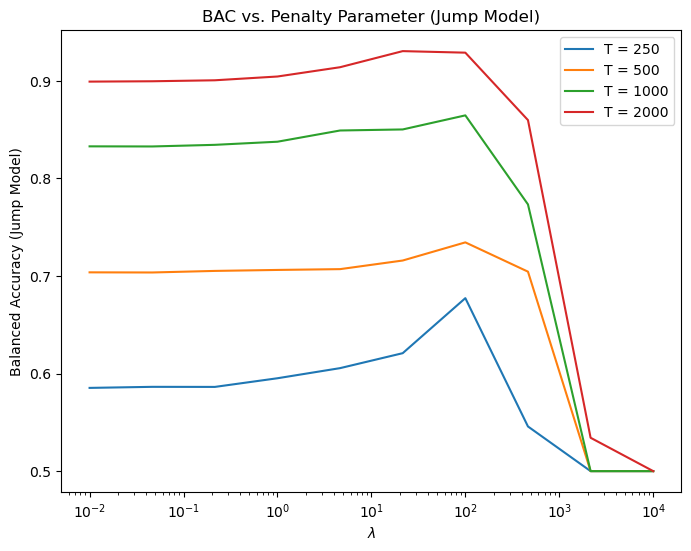

In [32]:
# Plot: BAC vs. lambda (with lambda on a log-scale) for each T
plt.figure(figsize=(8, 6))
for T_val in T_values_lam:
    sub_df = df_lambda[df_lambda["T"] == T_val].copy()
    sub_df.sort_values("lambda", inplace=True)  # ensure ascending order of lambda
    plt.plot(sub_df["lambda"], sub_df["BAC"], marker="", label=f"T = {T_val}")

plt.xscale("log")
plt.xlabel(r"$\lambda$")
plt.ylabel("Balanced Accuracy (Jump Model)")
plt.title("BAC vs. Penalty Parameter (Jump Model)")
plt.legend()
plt.show()

#### 6.2 Sparse Jump (kappa^2=9) lambda simulatino


In [33]:
# This section is similar to the previous Jump Model penalty sweep, but now for the **SparseJumpModel**. 
# We'll:
# 1. Vary \(\lambda\) over a log scale (e.g. \(10^{-2}\) to \(10^{4}\)).
# 2. For each simulation length \(T\in\{250,500,1000,2000\}\) and each \(\lambda\) value, we:
#    - Simulate data (with `simulate_data`).
#    - Build & standardize features (with `combine_features` + `DataClipperStd` + `StandardScalerPD`).
#    - Fit **SparseJumpModel** using `run_sparse_jump_model(..., max_feats=9)`.
#    - Compute Balanced Accuracy (BAC).
#    - Repeat multiple seeds and average.
# 3. Plot average BAC vs. \(\lambda\) (log-scale) for each \(T\), mirroring Figure&nbsp;2 style from the paper.

def simulate_for_lambda_sjump(T_val, lam, n_simulations):
    """
    For a given sample length T_val and penalty parameter lam, simulate n_simulations runs using the SparseJumpModel
    (with max_feats=9) and return the average Balanced Accuracy (BAC).
    """
    bac_list = []
    for seed in range(n_simulations):
        # 1) Simulate data
        y, true_states = simulate_data(T_val, random_state=seed)

        # 2) Build and standardize features
        Z = combine_features(y, l_list=[5, 13])
        Z_df = pd.DataFrame(Z)
        clipper = DataClipperStd(mul=3.0)
        scaler = StandardScalerPD()
        Z_clipped = clipper.fit_transform(Z_df)
        Z_scaled = scaler.fit_transform(Z_clipped)
        Z_scaled_arr = Z_scaled.values

        # 3) Fit SparseJumpModel with current lambda and max_feats=9
        pred_sjump = run_sparse_jump_model(
            Z_scaled_arr, 
            n_components=2, 
            lambda_=lam, 
            max_feats=9, 
            random_state=seed
        )

        # 4) Compute Balanced Accuracy (BAC)
        _, _, bac_val = compute_per_state_accuracy(true_states, pred_sjump)
        bac_list.append(bac_val)
        
    mean_bac = np.mean(bac_list)
    return {"T": T_val, "lambda": lam, "BAC": mean_bac}

# Define the lambda grid, simulation lengths, and number of simulations (seeds)
lambda_grid_sjump = np.logspace(-2, 4, 10)  # 7 values from 1e-2 to 1e4
T_values_sjump = [250, 500, 1000, 2000]
n_simulations_sjump = 30

# Run the simulations in parallel over all combinations of T and lambda
results_sjump = Parallel(n_jobs=-1)(
    delayed(simulate_for_lambda_sjump)(T_val, lam, n_simulations_sjump)
    for T_val in T_values_sjump
    for lam in lambda_grid_sjump
)

# Convert results to a DataFrame for plotting
df_sjump = pd.DataFrame(results_sjump)

/Users/vlad/Desktop/git/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/Users/vlad/Desktop/git/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/Users/vlad/Desktop/git/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/Users/vlad/Desktop/git/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label wa

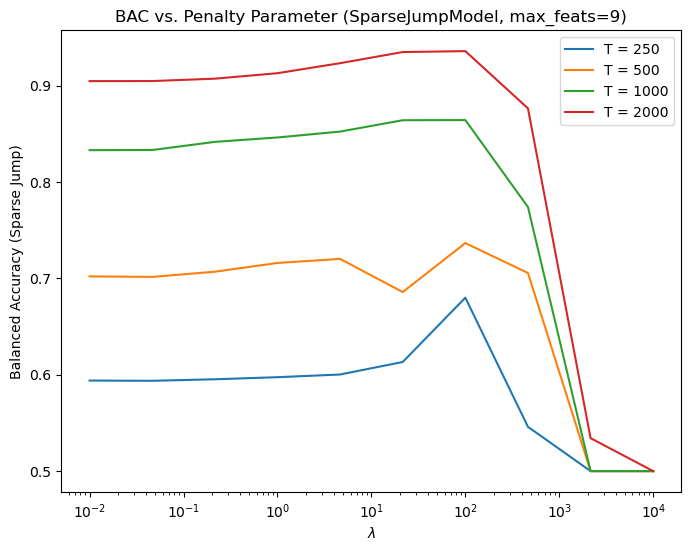

In [34]:
# ---- Plot: BAC vs. lambda for each T ----
plt.figure(figsize=(8, 6))
for T_val in T_values_sjump:
    sub_df = df_sjump[df_sjump["T"] == T_val].copy()
    sub_df.sort_values("lambda", inplace=True)  # ensure ascending order of lambda
    plt.plot(sub_df["lambda"], sub_df["BAC"], marker="", label=f"T = {T_val}")

plt.xscale("log")
plt.xlabel(r"$\lambda$")
plt.ylabel("Balanced Accuracy (Sparse Jump)")
plt.title("BAC vs. Penalty Parameter (SparseJumpModel, max_feats=9)")
plt.legend()
plt.show()